# QUANTUM LAYER SIMULATIONS FOR DEFENSE AGAINST DATA POISONING

## SETTINGS

### Imports

In [1]:
import netsquid as ns
from netsquid.qubits import create_qubits, operate, measure, depolarize
from netsquid.qubits.operators import H, X, Z
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy import stats
import pandas as pd

## SIMULATIONS BENIGN CHANNEL vs. MITM ATTACK

### QBER analysis

#### Environment and Simulation Constants

In [2]:
NUM_RUNS = 100          # statistical iterations
NUM_QUBITS = 2000       
CHANNEL_FIDELITY = 0.83 # Beer-Lambert attenuation
DEPOLAR_PROB = 1.0 - CHANNEL_FIDELITY

#### Simulation execution

In [3]:
def run_quantum_simulation(mitm_active=False):
    """
    simulates the bb84 protocol purely with quantum operators.
    the resulting qber is a consequence of theoretical physics
    """
    ns.sim_reset()
    
    # 1. alice: state preparation
    alice_bits = np.random.randint(0, 2, NUM_QUBITS)
    alice_bases = np.random.randint(0, 2, NUM_QUBITS) # 0=rectilinear(+), 1=diagonal(x)
    qubits = create_qubits(NUM_QUBITS)
    
    for i, q in enumerate(qubits):
        # bb84 encoding
        if alice_bits[i] == 1:
            operate(q, X) # bit 1 -> apply x
        if alice_bases[i] == 1:
            operate(q, H) # diagonal base -> apply hadamard

    # 2. the channel
    for q in qubits:
        # a) natural channel noise (always exists, with or without eve)
        # 'prob' is the chance of the qubit being replaced by a completely mixed state (white noise)
        # theoretical expected qber = prob / 2.
        
        # depolar_prob = 1.0 - channel_fidelity # ~17% depolarization.
        depolarize(q, prob=DEPOLAR_PROB) 

        # b) eve's interference 
        if mitm_active:
            # eve chooses a random base
            eve_basis = np.random.randint(0, 2)
            
            # if eve chooses diagonal base, apply h before measuring
            if eve_basis == 1:
                operate(q, H)
            
            # by measuring, eve destroys any superposition created by alice.
            # the qubit collapses to |0> or |1>.
            m_eve, _ = measure(q)
            
            # eve resends (intercept-resend)
            # the original qubit collapsed, it can be reused or a new one created.
            # if eve measured 1, the qubit is in |1>. if the base was diagonal, she applies h back.
            # if eve's base does not match alice's, she introduced irreversible error.
            if eve_basis == 1:
                operate(q, H)

    # 3. bob: measurement
    bob_bases = np.random.randint(0, 2, NUM_QUBITS)
    bob_results = []
    
    for i, q in enumerate(qubits):
        if bob_bases[i] == 1:
            operate(q, H)
        
        m_bob, _ = measure(q)
        bob_results.append(m_bob)

    # 4. sifting
    sifted_errors = 0
    total_sifted = 0
    
    for i in range(NUM_QUBITS):
        # comparison of bits where bases match
        if alice_bases[i] == bob_bases[i]:
            total_sifted += 1
            if alice_bits[i] != bob_results[i]:
                sifted_errors += 1
                
    if total_sifted == 0: return 0.0
    
    # returns percentage
    return (sifted_errors / total_sifted) * 100.0

In [8]:
print("simulating benign channel (depolarization noise only)...")
benign_data = [run_quantum_simulation(mitm_active=False) for _ in range(NUM_RUNS)]
b_mean, b_std = np.mean(benign_data), np.std(benign_data)

print("simulating mitm attack (intercept-resend + noise)...")
mitm_data = [run_quantum_simulation(mitm_active=True) for _ in range(NUM_RUNS)]
m_mean, m_std = np.mean(mitm_data), np.std(mitm_data)

print(f"\ntheoretical simulation results:")
print(f"attack  -> mean: {m_mean:.2f}% (expected > 25%)")
print(f"benign  -> mean: {b_mean:.2f}% (expected ~{(1-CHANNEL_FIDELITY)/2*100:.1f}%)")

simulating benign channel (depolarization noise only)...
simulating mitm attack (intercept-resend + noise)...

theoretical simulation results:
attack  -> mean: 29.08% (expected > 25%)
benign  -> mean: 8.36% (expected ~8.5%)


#### Plot

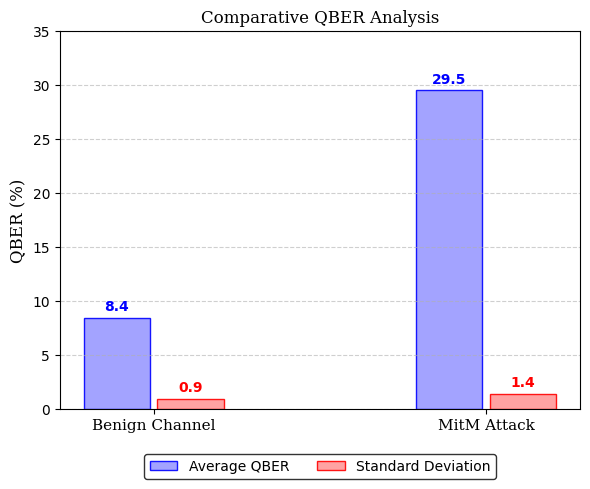

In [5]:
labels = ['Benign Channel', 'MitM Attack']
means = [b_mean, m_mean]
stds = [b_std, m_std]

x = np.arange(len(labels))
width = 0.2

fig, ax = plt.subplots(figsize=(6, 5))

bars_mean = ax.bar(x - width/1.8, means, width, label='Average QBER', 
                   color='#9999ff', edgecolor='blue', alpha=0.9)

bars_std = ax.bar(x + width/1.8, stds, width, label='Standard Deviation', 
                  color='#ff9999', edgecolor='red', alpha=0.9)

ax.set_ylabel('QBER (%)', fontsize=12, family='serif')
ax.set_title('Comparative QBER Analysis', fontsize=12, family='serif')
ax.set_xticks(x)
ax.set_xticklabels(labels, fontsize=11, family='serif')
ax.set_ylim(0, 35) 
ax.grid(axis='y', linestyle='--', alpha=0.6)

# num labels
def add_labels(rects, color):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.1f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3), textcoords="offset points",
                    ha='center', va='bottom', color=color, weight='bold')

add_labels(bars_mean, 'blue')
add_labels(bars_std, 'red')

ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1),
          ncol=2, frameon=True, edgecolor='black')

plt.tight_layout()
plt.show()

### Cumulative QBER evolution

#### Environment and Simulation Constants

In [6]:
NUM_RUNS = 100            # statistical iterations
NUM_QUBITS = 2000       
CHANNEL_FIDELITY = 0.83   # Beer-Lambert attenuation
DEPOLAR_PROB = 1.0 - CHANNEL_FIDELITY
## PLOT SETTINGS
CHECKPOINT_STEP = 50      # calculate qber every x qubits (points on x-axis)
NUM_AVERAGING_RUNS = 10   # how many times to run the scenario to smooth the graph line
SECURITY_THRESHOLD = 11.0 # security threshold for the graph

#### Simulation execution

In [10]:
def run_single_temporal_evolution(mitm_active=False):
    """
    simulates one long transmission sequence and returns the qber evolution.
    """
    ns.sim_reset()
    
    sifted_bits_count = 0
    sifted_errors_count = 0
    
    checkpoint_x = []
    qber_y = []

    # sequential loop: transmits qubit by qubit
    for seq_idx in range(1, NUM_QUBITS + 1):
        
        # 1. alice prepares 
        q = create_qubits(1)[0]
        alice_bit = np.random.randint(0, 2)
        alice_basis = np.random.randint(0, 2) # 0=z, 1=x

        if alice_bit == 1: operate(q, X)
        if alice_basis == 1: operate(q, H)

        # 2. quantum channel (physical) 
        # a) natural noise
        depolarize(q, prob=DEPOLAR_PROB)

        # b) mitm attack (if active)
        if mitm_active:
            eve_basis = np.random.randint(0, 2)
            if eve_basis == 1: operate(q, H)
            measure(q) # collapse happens here
            # if eve measured in x base and wants to resend, apply h again
            # if she measured in z base, the qubit is already in |0> or |1>
            if eve_basis == 1: operate(q, H)

        # 3. bob measures
        bob_basis = np.random.randint(0, 2)
        if bob_basis == 1: operate(q, H)
        bob_result, _ = measure(q)

        # 4. instantaneous sifting 
        # only counts if bases match
        if alice_basis == bob_basis:
            sifted_bits_count += 1
            if alice_bit != bob_result:
                sifted_errors_count += 1
        
        # 5. checkpoint: calculate accumulated qber 
        # checks if it's time to record a point on the graph
        if seq_idx % CHECKPOINT_STEP == 0:
            checkpoint_x.append(seq_idx)
            if sifted_bits_count > 0:
                current_qber = (sifted_errors_count / sifted_bits_count) * 100.0
            else:
                current_qber = 0.0
            qber_y.append(current_qber)
            
    return checkpoint_x, qber_y

In [17]:
print(f"starting {NUM_AVERAGING_RUNS} runs for temporal averaging...")

# 1. benign scenario
print("simulating benign scenario...")
benign_trajectories = []
for _ in range(NUM_AVERAGING_RUNS):
    x_axis, y_qber = run_single_temporal_evolution(mitm_active=False)
    benign_trajectories.append(y_qber)
# calculates the average of the trajectories (y-axis)
avg_benign_y = np.mean(benign_trajectories, axis=0)

# 2. mitm scenario
print("simulating mitm scenario...")
mitm_trajectories = []
for _ in range(NUM_AVERAGING_RUNS):
    x_axis, y_qber = run_single_temporal_evolution(mitm_active=True)
    mitm_trajectories.append(y_qber)
# calculates the average of the trajectories (y-axis)
avg_mitm_y = np.mean(mitm_trajectories, axis=0)

print('simulation completed')

starting 10 runs for temporal averaging...
simulating benign scenario...
simulating mitm scenario...
simulation completed


#### Plot

  agg_filter: a filter function, which takes a (m, n, 3) float array and a dpi value, and returns a (m, n, 3) array and two offsets from the bottom left corner of the image
  alpha: float or None
  animated: bool
  antialiased: bool
  backgroundcolor: :mpltype:`color`
  bbox: dict with properties for `.patches.FancyBboxPatch`
  clip_box: `~matplotlib.transforms.BboxBase` or None
  clip_on: bool
  clip_path: Patch or (Path, Transform) or None
  color or c: :mpltype:`color`
  figure: `~matplotlib.figure.Figure` or `~matplotlib.figure.SubFigure`
  fontfamily or family or fontname: {FONTNAME, 'serif', 'sans-serif', 'cursive', 'fantasy', 'monospace'}
  fontproperties or font or font_properties: `.font_manager.FontProperties` or `str` or `pathlib.Path`
  fontsize or size: float or {'xx-small', 'x-small', 'small', 'medium', 'large', 'x-large', 'xx-large'}
  fontstretch or stretch: {a numeric value in range 0-1000, 'ultra-condensed', 'extra-condensed', 'condensed', 'semi-condensed', 'normal', 

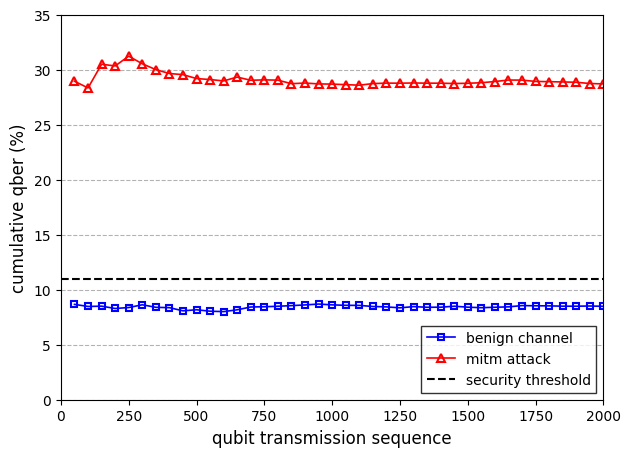

In [20]:
fig, ax = plt.subplots(figsize=(7, 5))

# benign plot (blue line with squares)
ax.plot(x_axis, avg_benign_y, label='benign channel', 
        color='blue', marker='s', markersize=5, linestyle='-', linewidth=1.2, fillstyle='none', markeredgewidth=1.5)

# mitm plot (red line with triangles)
ax.plot(x_axis, avg_mitm_y, label='mitm attack', 
        color='red', marker='^', markersize=6, linestyle='-', linewidth=1.2, fillstyle='none', markeredgewidth=1.5)

# security threshold plot (black dashed line)
ax.axhline(y=SECURITY_THRESHOLD, color='black', linestyle='--', linewidth=1.5, label='security threshold')

# layout customization
ax.set_xlabel('qubit transmission sequence', fontsize=12)
ax.set_ylabel('cumulative qber (%)', fontsize=12)
ax.set_ylim(0, 35) # adjust y-axis if necessary
ax.set_xlim(0, NUM_QUBITS)

# scientific style horizontal grid
ax.yaxis.grid(True, linestyle='--', which='major', color='grey', alpha=0.6)

# legend (box in the lower right corner)
legend = ax.legend(loc='lower right', fancybox=False, shadow=False, frameon=True, edgecolor='black')
plt.setp(legend.get_texts())

plt.tight_layout()
# plt.savefig('temporal_qber_evolution.png', dpi=300, bbox_inches='tight')
plt.show()

### QBER Probability Density Function 

#### Environment and Simulation Constants

In [21]:
NUM_EXPERIMENTS = 300     # number of times the protocol is run to generate statistics
NUM_QUBITS = 2000         
CHANNEL_FIDELITY = 0.83   
DEPOLAR_PROB = 1.0 - CHANNEL_FIDELITY
SECURITY_THRESHOLD = 11.0 

#### Simulation execution

In [22]:
def run_block_simulation(mitm_active=False):
    """
    runs one full transmission block and returns the final qber of that block.
    """
    ns.sim_reset()
    
    # 1. preparation (alice)
    alice_bits = np.random.randint(0, 2, NUM_QUBITS)
    alice_bases = np.random.randint(0, 2, NUM_QUBITS)
    qubits = create_qubits(NUM_QUBITS)
    
    for i, q in enumerate(qubits):
        if alice_bits[i] == 1: operate(q, X)
        if alice_bases[i] == 1: operate(q, H)

    # 2. channel and eve
    # natural noise
    for q in qubits:
        depolarize(q, prob=DEPOLAR_PROB)
        
        # attack
        if mitm_active:
            eve_basis = np.random.randint(0, 2)
            if eve_basis == 1: operate(q, H)
            measure(q) # wavefunction collapse
            if eve_basis == 1: operate(q, H)

    # 3. measurement (bob)
    bob_bases = np.random.randint(0, 2, NUM_QUBITS)
    bob_results = []
    for i, q in enumerate(qubits):
        if bob_bases[i] == 1: operate(q, H)
        m, _ = measure(q)
        bob_results.append(m)

    # 4. final block qber calculation
    sifted_errors = 0
    total_sifted = 0
    
    for i in range(NUM_QUBITS):
        if alice_bases[i] == bob_bases[i]:
            total_sifted += 1
            if alice_bits[i] != bob_results[i]:
                sifted_errors += 1
                
    if total_sifted == 0: return 0.0
    return (sifted_errors / total_sifted) * 100.0

In [23]:
print(f"collecting statistics from {NUM_EXPERIMENTS} independent experiments...")

# DATA COLLECTION
# list of resulting qbers from the benign scenario
benign_samples = [run_block_simulation(False) for _ in range(NUM_EXPERIMENTS)]

# list of resulting qbers from the attack scenario
mitm_samples = [run_block_simulation(True) for _ in range(NUM_EXPERIMENTS)]

# STATISTICAL ANALYSIS (FIT)
# calculate the actual mean and standard deviation generated by the simulation
mu_benign, std_benign = np.mean(benign_samples), np.std(benign_samples)
mu_mitm, std_mitm = np.mean(mitm_samples), np.std(mitm_samples)

print(f"final statistics:")
print(f"benign -> mean: {mu_benign:.2f}%, std: {std_benign:.2f}")
print(f"attack -> mean: {mu_mitm:.2f}%, std: {std_mitm:.2f}")

collecting statistics from 300 independent experiments...
final statistics:
benign -> mean: 8.60%, std: 0.86
attack -> mean: 29.27%, std: 1.44


#### Plot

  agg_filter: a filter function, which takes a (m, n, 3) float array and a dpi value, and returns a (m, n, 3) array and two offsets from the bottom left corner of the image
  alpha: float or None
  animated: bool
  antialiased: bool
  backgroundcolor: :mpltype:`color`
  bbox: dict with properties for `.patches.FancyBboxPatch`
  clip_box: `~matplotlib.transforms.BboxBase` or None
  clip_on: bool
  clip_path: Patch or (Path, Transform) or None
  color or c: :mpltype:`color`
  figure: `~matplotlib.figure.Figure` or `~matplotlib.figure.SubFigure`
  fontfamily or family or fontname: {FONTNAME, 'serif', 'sans-serif', 'cursive', 'fantasy', 'monospace'}
  fontproperties or font or font_properties: `.font_manager.FontProperties` or `str` or `pathlib.Path`
  fontsize or size: float or {'xx-small', 'x-small', 'small', 'medium', 'large', 'x-large', 'xx-large'}
  fontstretch or stretch: {a numeric value in range 0-1000, 'ultra-condensed', 'extra-condensed', 'condensed', 'semi-condensed', 'normal', 

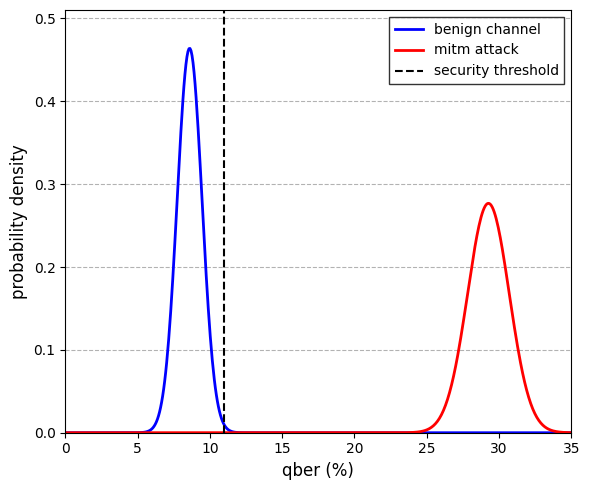

In [25]:
fig, ax = plt.subplots(figsize=(6, 5))

# generating x-axis to draw the curves (from 0% to 35%)
x_axis = np.linspace(0, 35, 500)

# generating probability density function (pdf) curves based on simulated data
pdf_benign = norm.pdf(x_axis, mu_benign, std_benign)
pdf_mitm = norm.pdf(x_axis, mu_mitm, std_mitm)

# benign curve plot
ax.plot(x_axis, pdf_benign, color='blue', linewidth=2, label='benign channel')

# attack curve plot
ax.plot(x_axis, pdf_mitm, color='red', linewidth=2, label='mitm attack')
# ax.fill_between(x_axis, pdf_mitm, color='red', alpha=0.1)

# threshold line
ax.axvline(x=SECURITY_THRESHOLD, color='black', linestyle='--', linewidth=1.5, label='security threshold')

# layout customization 
ax.set_xlabel('qber (%)', fontsize=12)
ax.set_ylabel('probability density', fontsize=12)
ax.set_ylim(0, max(max(pdf_benign), max(pdf_mitm)) * 1.1) 
ax.set_xlim(0, 35)

# horizontal grid
ax.yaxis.grid(True, linestyle='--', which='major', color='grey', alpha=0.6)

# legend
legend = ax.legend(loc='upper right', fancybox=False, shadow=False, frameon=True, edgecolor='black')
plt.setp(legend.get_texts())

plt.tight_layout()
# plt.savefig('qber_pdf_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

### Detection metrics

#### Environment and Simulation Constants

In [2]:
NUM_RUNS = 100            
NUM_QUBITS = 2000        
CHANNEL_FIDELITY = 0.83   
DEPOLAR_PROB = 1.0 - CHANNEL_FIDELITY
SECURITY_THRESHOLD = 11.0 

#### Simulation execution

In [7]:
def run_simulation_batch(mitm_active):
    """
    runs a batch of simulations and returns a list of measured qbers.
    """
    qber_results = []
    
    for _ in range(NUM_RUNS):
        ns.sim_reset()
        
        # 1. preparation
        alice_bits = np.random.randint(0, 2, NUM_QUBITS)
        alice_bases = np.random.randint(0, 2, NUM_QUBITS)
        qubits = create_qubits(NUM_QUBITS)
        
        for i, q in enumerate(qubits):
            if alice_bits[i] == 1: operate(q, X)
            if alice_bases[i] == 1: operate(q, H)

        # 2. channel and eve
        for q in qubits:
            depolarize(q, prob=DEPOLAR_PROB)
            
            if mitm_active:
                eve_basis = np.random.randint(0, 2)
                if eve_basis == 1: operate(q, H)
                measure(q) 
                if eve_basis == 1: operate(q, H)

        # 3. bob
        bob_bases = np.random.randint(0, 2, NUM_QUBITS)
        bob_results = []
        for i, q in enumerate(qubits):
            if bob_bases[i] == 1: operate(q, H)
            m, _ = measure(q)
            bob_results.append(m)

        # 4. run qber
        sifted_errors = 0
        total_sifted = 0
        for i in range(NUM_QUBITS):
            if alice_bases[i] == bob_bases[i]:
                total_sifted += 1
                if alice_bits[i] != bob_results[i]:
                    sifted_errors += 1
        
        qber = (sifted_errors / total_sifted * 100.0) if total_sifted > 0 else 0.0
        qber_results.append(qber)
        
    return np.array(qber_results)

# statistical functions
def calc_confidence_interval_mean(data, confidence=0.95):
    """calculates ci for mean (qber)"""
    n = len(data)
    m = np.mean(data)
    se = stats.sem(data) # standard error of the mean
    h = se * stats.t.ppf((1 + confidence) / 2., n-1)
    return m, m-h, m+h

def calc_confidence_interval_proportion(count, nobs, confidence=0.95):
    """
    calculates ci for proportion (tpr/fpr) using wilson interval.
    ideal for when the rate is 0% or 100%.
    """
    # if 100% or 0%, we use a robust approximation to avoid calculation errors
    ratio = count / nobs
    
    # wilson score interval
    z = stats.norm.ppf((1 + confidence) / 2)
    p = ratio
    denominator = 1 + z**2/nobs
    center_adjusted_probability = p + z*z / (2*nobs)
    adjusted_standard_deviation = np.sqrt((p*(1 - p) + z*z / (4*nobs)) / nobs)
    
    lower_bound = (center_adjusted_probability - z * adjusted_standard_deviation) / denominator
    upper_bound = (center_adjusted_probability + z * adjusted_standard_deviation) / denominator
    
    # clamp between 0 and 1
    lower_bound = max(0.0, lower_bound)
    upper_bound = min(1.0, upper_bound)
    
    return ratio, lower_bound, upper_bound

In [8]:
print(f"running {NUM_RUNS} benign simulations...")
benign_qbers = run_simulation_batch(mitm_active=False)

print(f"running {NUM_RUNS} attack simulations...")
mitm_qbers = run_simulation_batch(mitm_active=True)

# DETECTION ANALYSIS
# true/false analysis
# false positive: benign but qber > threshold
false_positives = np.sum(benign_qbers > SECURITY_THRESHOLD)
# true positive: attack and qber > threshold
true_positives = np.sum(mitm_qbers > SECURITY_THRESHOLD)

# metrics calculation
# tpr (sensitivity)
tpr, tpr_low, tpr_high = calc_confidence_interval_proportion(true_positives, NUM_RUNS)
# fpr (fall-out)
fpr, fpr_low, fpr_high = calc_confidence_interval_proportion(false_positives, NUM_RUNS)

# protocol abortion rate 
abortion_rate = tpr # in an attack scenario, it is equal to tpr
abort_low, abort_high = tpr_low, tpr_high

# qber mean calculation
mean_benign, ben_low, ben_high = calc_confidence_interval_mean(benign_qbers)
mean_mitm, mitm_low, mitm_high = calc_confidence_interval_mean(mitm_qbers)

running 100 benign simulations...
running 100 attack simulations...


#### Summary

In [9]:
data = {
    "Metric": [
        "True Positive Rate",
        "False Positive Rate", 
        "Detection Latency", 
        "Protocol Abortion Rate",
        "Average QBER (Benign)",
        "Average QBER (MitM)"
    ],
    "Value": [
        f"{tpr*100:.1f}%",
        f"{fpr*100:.1f}%",
        "Immediate", # qualitative, based on fig 4
        f"{abortion_rate*100:.1f}%",
        f"{mean_benign:.1f}%",
        f"{mean_mitm:.1f}%"
    ],
    "Confidence Interval (95%)": [
        f"{tpr_low*100:.1f}% - {tpr_high*100:.1f}%",
        f"{fpr_low*100:.1f}% - {fpr_high*100:.1f}%",
        "-",
        f"{abort_low*100:.1f}% - {abort_high*100:.1f}%",
        f"{ben_low:.1f}% - {ben_high:.1f}%",
        f"{mitm_low:.1f}% - {mitm_high:.1f}%"
    ]
}

df = pd.DataFrame(data)

print("\n=== TABLE I GENERATED VIA NETSQUID SIMULATION ===")
print(df.to_string(index=False))


=== TABLE I GENERATED VIA NETSQUID SIMULATION ===
                Metric     Value Confidence Interval (95%)
    True Positive Rate    100.0%            96.3% - 100.0%
   False Positive Rate      0.0%               0.0% - 3.7%
     Detection Latency Immediate                         -
Protocol Abortion Rate    100.0%            96.3% - 100.0%
 Average QBER (Benign)      8.5%               8.4% - 8.7%
   Average QBER (MitM)     29.3%             29.0% - 29.5%
